In [62]:
import re
import random
import pandas as pd
import hashlib

In [63]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

# if cards_to_age['age'].mean() > 80: age_factor = .5
# else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.5) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())
cards_to_age['head_count'] = cards_to_age.groupby('head')['head'].transform("count")


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [64]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
PP365 Guest Users,1.371430,1.371430,1.371430,1
Azure Functions + PP365,64.719582,32.359791,38.515813,2
OAuth 2.0 RFC6749,195.013452,24.376681,47.219201,8
Django,465.159342,11.628984,21.627949,40
Node.js and Vite,489.232194,11.932493,22.824252,41
pfSense,541.750959,45.145913,131.801035,12
FSLogix,597.687908,74.710988,168.082655,8
CCH Tax Forms Project,690.468070,32.879432,97.697359,21
Accounting,740.172152,43.539538,111.768523,17
Asynchronous Python,864.599598,50.858800,90.868489,17


# Histogram

sum of ages: ~45852.51


<Axes: >

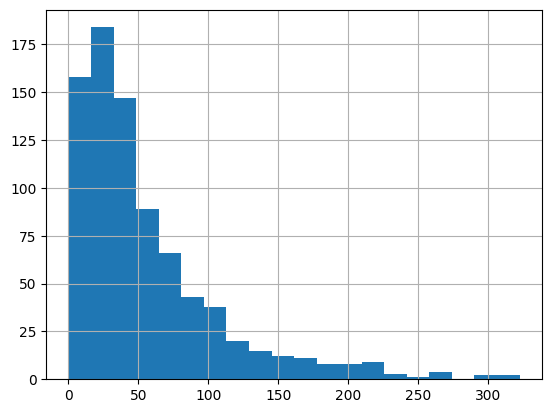

In [65]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~45852.51


<Axes: >

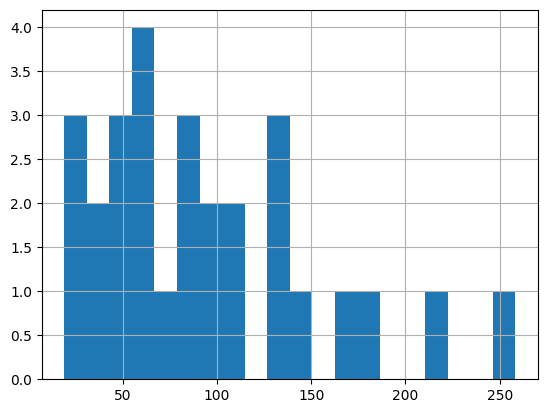

In [66]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Azure VM + Developer']['age'].hist(bins=20)

# Completely Random Shuffle

In [67]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [68]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# N-fold shuffle


## Age Sum

In [69]:
# n = 3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [70]:
n=3
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)

Cards found: 820
Total card age: 45852.51


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold
181,VMWare,Host Failure\n\nWhen a physical ESXi host beco...,50554350b937a4d45efe1e2ea91d1c85,-312.307506,-104.151318,312.307506,1458.118450,0.103038,14,0,0
182,VMWare,vCenter Server\n\nVMware's centralized managem...,432056b63359a599b8b27f7ad669c9c9,-126.324260,-104.151318,312.307506,1458.118450,0.103038,14,3,0
183,VMWare,vSphere Client\n\nA graphical user interface (...,87c98db9246a517fa53393f1fcf98548,-84.972786,-104.151318,312.307506,1458.118450,0.103038,14,6,0
184,VMWare,ESXi Lockdown Mode\n\nA security feature that ...,55aaeadf608c3e2138495183a0560aea,-58.570253,-104.151318,312.307506,1458.118450,0.103038,14,9,0
185,VMWare,ESXi Datastore\n\nA storage container used by ...,5185f47bb74f4d0f63c3cab0bb109d16,-34.135465,-104.151318,312.307506,1458.118450,0.103038,14,12,0
186,Azure VM + Developer,.env File\nA flat file storing environment var...,5c23b6d70d4d3563ba79097e051516c5,-258.237904,-93.825071,258.237904,2627.101991,0.308625,28,0,0
187,Azure VM + Developer,"REPL\nShort for “Read-Eval-Print Loop,” an int...",6378e9227ac639d2079f75cd8824e0e1,-173.821118,-93.825071,258.237904,2627.101991,0.308625,28,3,0
188,Azure VM + Developer,Build Tool\nA program used to automate the com...,5b92559a8c128584525a8a282d878e5e,-128.839927,-93.825071,258.237904,2627.101991,0.308625,28,6,0
189,Azure VM + Developer,Azure Policy\nA governance tool that defines a...,c2962cf6d9fb6d8aa1d619fc6fe36ff6,-108.591920,-93.825071,258.237904,2627.101991,0.308625,28,9,0
190,Azure VM + Developer,Dev Containers\nA container-based dev environm...,8fd2c27cc19f1e28f8e6416950131191,-83.775238,-93.825071,258.237904,2627.101991,0.308625,28,12,0


## Age Max

In [71]:
# n = 5
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [72]:
# n=5
# # existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
#     existing_cards['subject_highest_age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_count', 'subject_highest_age', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [73]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [74]:
existing_cards.head(10)['age'].sum()

np.float64(-1369.5763779037543)

In [75]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold
219,TSQL,Stored Procedures:\n\nPrecompiled TSQL routine...,1c1c29f98d6c0bd8774d3c31bfcdd3e4,-322.448080,-69.839309,322.448080,1676.143405,0.705314,24,0,0
181,VMWare,Host Failure\n\nWhen a physical ESXi host beco...,50554350b937a4d45efe1e2ea91d1c85,-312.307506,-104.151318,312.307506,1458.118450,0.103038,14,0,0
87,Terraform Codebox,Process segmentation fault (Segmentation fault...,e4cf055569f377aaeff23124919e4d27,-304.637837,-67.352870,304.637837,3300.290636,0.591749,49,0,0
41,PnP PowerShell,PSCredential (Microsoft.PowerShell.Security)\n...,58979b94f2077e07481d767d7e748fc9,-291.999634,-77.683454,291.999634,2796.604353,0.716788,36,0,0
157,Python,Q:\nHow can you measure the performance of a g...,13eda1c228af6c0fae5fc403983fa80e,-263.079403,-57.817166,263.079403,4105.018805,0.885342,71,0,0
147,Azure Compute Gallery,Compute Gallery Resource – The top-level conta...,cd4e5ebc6131cac516f3b36cdc1af298,-262.507435,-90.981763,262.507435,2547.489377,0.231659,28,0,0
254,Power BI,"Q: In a Pro workspace, which Service-side feat...",25b487580bae6b89adcd0c6909e8aa20,-259.502968,-61.006391,259.502968,2013.210888,0.931024,33,0,0
186,Azure VM + Developer,.env File\nA flat file storing environment var...,5c23b6d70d4d3563ba79097e051516c5,-258.237904,-93.825071,258.237904,2627.101991,0.308625,28,0,0
429,Azure Compute Gallery,One Compute Gallery Per Subscription – ACG is ...,7b7b4f84c6bc6891a0e1e7cf19f2922e,-257.184720,-90.981763,262.507435,2547.489377,0.231659,28,1,1
126,JavaScript Concepts,"A LIFO (Last-In, First-Out) stack is a way of ...",177fe59b3fb370453b5cd806c1c92ef3,-239.180897,-69.372717,239.180897,4301.108479,0.731899,62,0,0


In [79]:
f"Average age: {abs(existing_cards['age'].mean()):.3f}"

'Average age: 55.918'